canva : https://www.canva.com/design/DAGGPnufpsw/O4_nFFkIX9xxsl3wbxmdTg/edit?utm_content=DAGGPnufpsw&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton

***High-Dimensional-Deep-Learning - 5A INSA***

CALLEN Balthazar, DELON Paul, GRANIER Sacha, MOSER Nina et PLEYNET-JESUS Léa

---

# Mini projet : "Transformer Classifier"

---

Ce projet a pour but de construire et d'entrainer un modèle de Transformer pour la classification de texte. Nous utiliserons le jeu de données *Emotion Dataset* disponible à l'adresse suivante : https://huggingface.co/datasets/dair-ai/emotion.

Dans un soucis pédagogique, nous nous efforcerons de commenter le code et d'interpréter chacune des cellules et des résultats présentés.

## 1 - Motivations

---

La classification est une tâche de machine learning permettant de classer des données selon des caractéristiques communes. Elle peut être appliqué à des données numériques, des images, des mots ou encore des textes entiers. L'objectif d'un modèle de classification est de trier de manière performante des données à partir d'un apprentissage réalisé sur un set d'entrainement. L'enjeu est de créer un modèle qui puisse être utilisé sur différents jeux de données similaires. Pour cela, le sur-apprentissage doit être évité afin de ne pas être performant uniquement à l'entrainement, mais le modèle doit quand même être suffisamment précis pour pouvoir être utilisé et généralisé.

Dans ce projet nous abordons la classification de texte avec un modèle de *Transformer*. Nous disposons d'un jeu de données contenant des tweets auquels sont associés 6 émotions différentes. La classification pour ce type de données peut être utile notamment dans la régulation et la modération des publications sur les réseaux sociaux, qui voient de plus en plus des messages de haine, de violence et de désinformation circuler.

## 2 - Préparation des données

---

Nous utilisons donc le jeu de données *Emotion Dataset* qui regroupe un ensemble de tweets (messages postés sur la plateforme Twitter, nouvellement renommé X) contenant 6 émotions courantes : la tristesse, la joie, l'amour, la colère, la peur et la surprise. Il est structuré de la manière suivante : chaque texte est sous la forme d'un *string* auquel est associé un label permettant la classication : sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

### 2.1 - Chargement des librairies

In [ ]:
# import sys
# !{sys.executable} -m pip install tiktoken
# !pip install tiktoken
# import sys
# !{sys.executable} -m pip install wordcloud
!pip install tiktoken
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.8 MB/s eta 0:00:00


In [ ]:
# Chargement des librairies nécessaires à la compilation

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import torch.nn as nn
import tiktoken
import math
import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 2.2 - Chargement des données

In [ ]:
# Importation des données

ds = load_dataset("dair-ai/emotion", "split")

# Prise en main des données :

print(ds) # Architecture du jeu de données avec la séparation train/validation/test
print("---------------------------------------------------------------")

print("Voici les  premiers exemple du jeu de données d'entrainement :")
train = ds['train'].to_pandas()
print(train.head())                   # Affiche les premières lignes
print("Voici la répartition des labels pour le jeu d'entrainement :")
print(train['label'].value_counts())  # Distribution des émotions
print("---------------------------------------------------------------")

print("Voici les premiers exemple du jeu de données de validation :")
validation = ds['validation'].to_pandas()
print(validation.head())
print("Voici la répartition des labels pour le jeu de validation :")
print(validation['label'].value_counts())
print("---------------------------------------------------------------")


print("Voici les premiers exemple du jeu de données de test :")
test = ds['test'].to_pandas()
print(test.head())
print("Voici la répartition des labels pour le jeu de test :")
print(test['label'].value_counts())
print("---------------------------------------------------------------")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
---------------------------------------------------------------
Voici les  premiers exemple du jeu de données d'entrainement :
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
Voici la répartition des labels pour le jeu d'entrainement :
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64
---------------------------------------------------------------
Voici les 

**Observations :**
* Le jeu de donnée est séparé en 3 sous jeux de données : entrainement, validation, test.
* Le jeu d'entrainement contient le plus de données (ce qui est normal) : 16 000 exemples.
* Les jeux de validation et de test en contiennent moins : 2 000 chacun.
* Nous obtenons pour chacun des jeux le nombre de label de chaque émotions. Afin de voir si celles-ci sont présentes dans les mêmes proportions dans chacun des jeux, nous allons calculer et représenter leur proportion.

---

## 2.3 - Analyse exploratoire

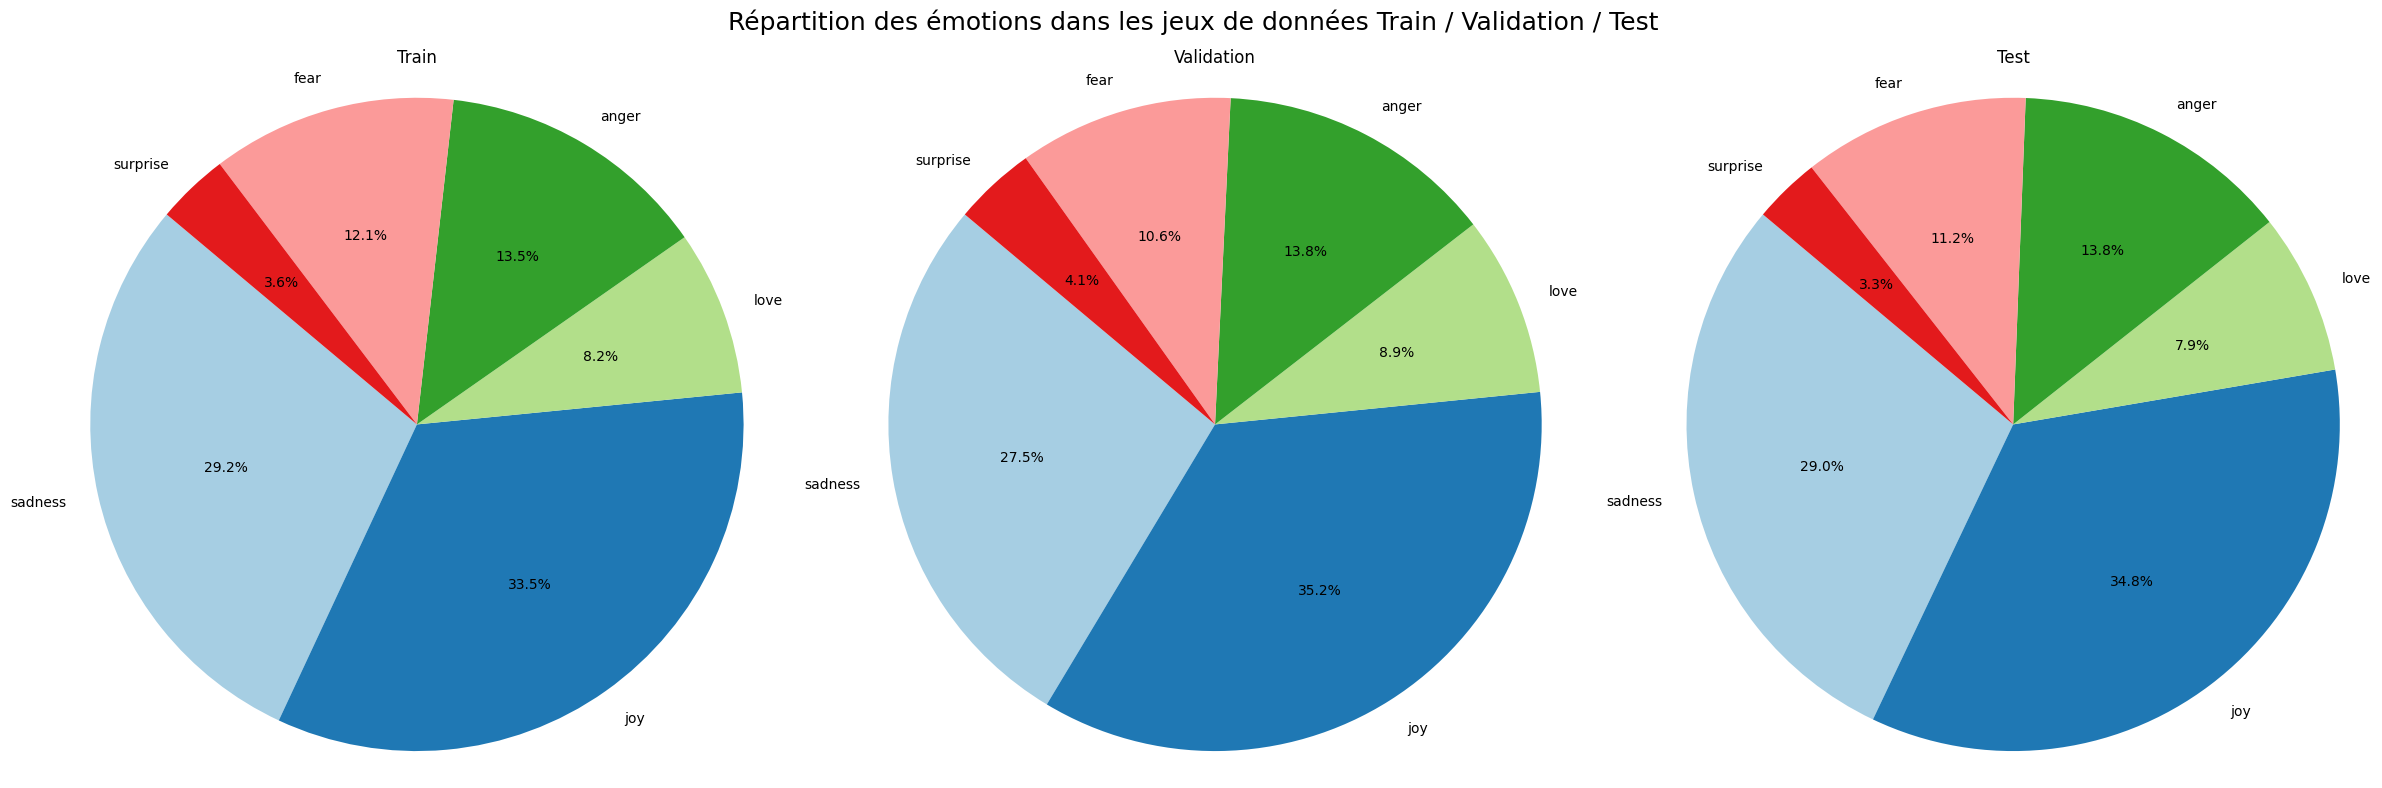

In [ ]:
# Vecteur des différentes émotions :
label_names =  ds['train'].features['label'].names # On aurait pu prendre dans validation/test ce sont les mêmes

# Train :
train_label = train['label'].value_counts().sort_index().values # Obtenir les comptes de chaque label

# Validation :
validation_label = validation['label'].value_counts().sort_index().values

# Test :
test_label = test['label'].value_counts().sort_index().values

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Train
axes[0].pie(
    train_label,
    labels=label_names,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
axes[0].set_title("Train")
axes[0].axis('equal')

# Validation
axes[1].pie(
    validation_label,
    labels=label_names,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
axes[1].set_title("Validation")
axes[1].axis('equal')

# Test
axes[2].pie(
    test_label,
    labels=label_names,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
axes[2].set_title("Test")
axes[2].axis('equal')

# Titre général
plt.suptitle("Répartition des émotions dans les jeux de données Train / Validation / Test", fontsize=18)
plt.tight_layout()
plt.show()

**Observations :**
* Nous obtenons la proportion de chaque émotion dans chaque sous jeu de données.
* L'émotion "joie" semble être sur-représenté : autour de 34% dans chaque jeu de données.
* L'émotion "tristesse" est elle aussi très présente : autour de 28%.
* Les émotions "amour", "peur" et "colère" varient respectivement autour de 8, 12 et 13%.
* La "surprise" est nettement sous représentée avec environ 3 ou 4% d'occurence.

---

Nous proposons maintenant d'analyser la taille de chaque texte dans les 3 sous jeux de données.

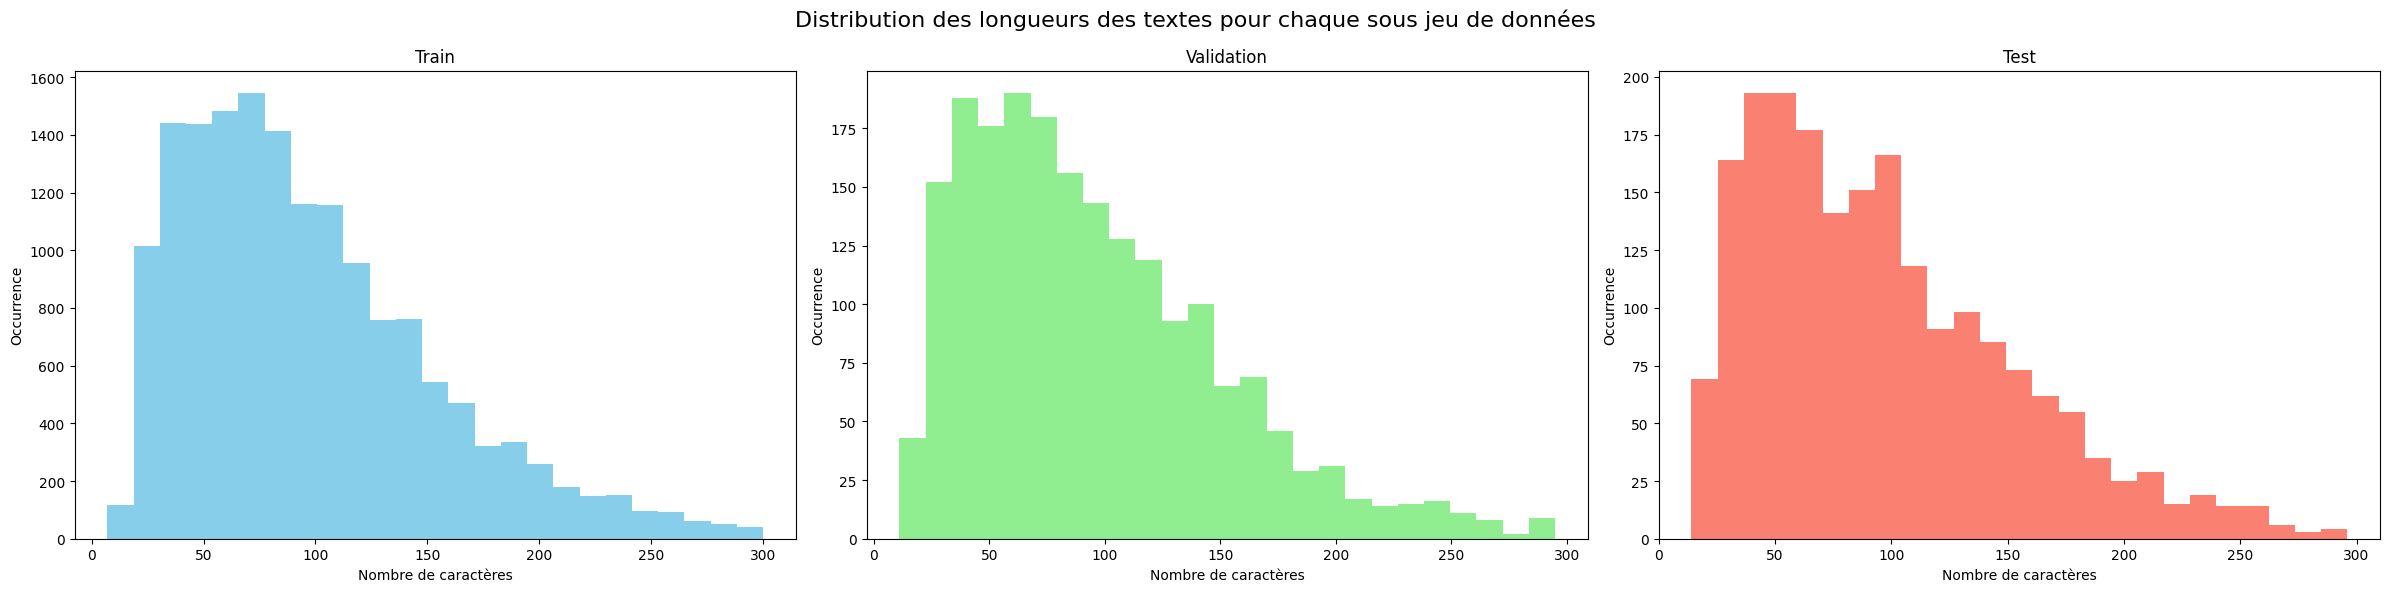

In [ ]:
# Ajout de colonnes de longueur pour chaque jeu de données
train['text_length'] = train['text'].apply(len)
validation['text_length'] = validation['text'].apply(len)
test['text_length'] = test['text'].apply(len)

# Subdivision de l'affichage
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Histogramme - Train
axes[0].hist(train['text_length'], bins=25, color='skyblue')
axes[0].set_title("Train")
axes[0].set_xlabel("Nombre de caractères")
axes[0].set_ylabel("Occurrence")

# Histogramme - Validation
axes[1].hist(validation['text_length'], bins=25, color='lightgreen')
axes[1].set_title("Validation")
axes[1].set_xlabel("Nombre de caractères")
axes[1].set_ylabel("Occurrence")

# Histogramme - Test
axes[2].hist(test['text_length'], bins=25, color='salmon')
axes[2].set_title("Test")
axes[2].set_xlabel("Nombre de caractères")
axes[2].set_ylabel("Occurrence")

# Mise en page
plt.suptitle("Distribution des longueurs des textes pour chaque sous jeu de données", fontsize=16)
plt.tight_layout()
plt.show()

**Observations :**
* On observe la même distribution de longueur de texte pour les 3 sous jeux de données.
* Une grande partie des textes a entre 40 et 100 caractères.
* Très peu de textes ont moins de 40 caractères.
* Il y a également de nombreux textes ayant entre 100 et 200 caractères.
* Très peu de textes ont plus de 200 caractères.

---

Désormais, nous allons analyser quels sont les mots qui reviennent les plus fréquemment pour chaque émotion. Nous utilisons pour cela des nuages de mots que nous réalisons à l'aide du package *WordCloud*.

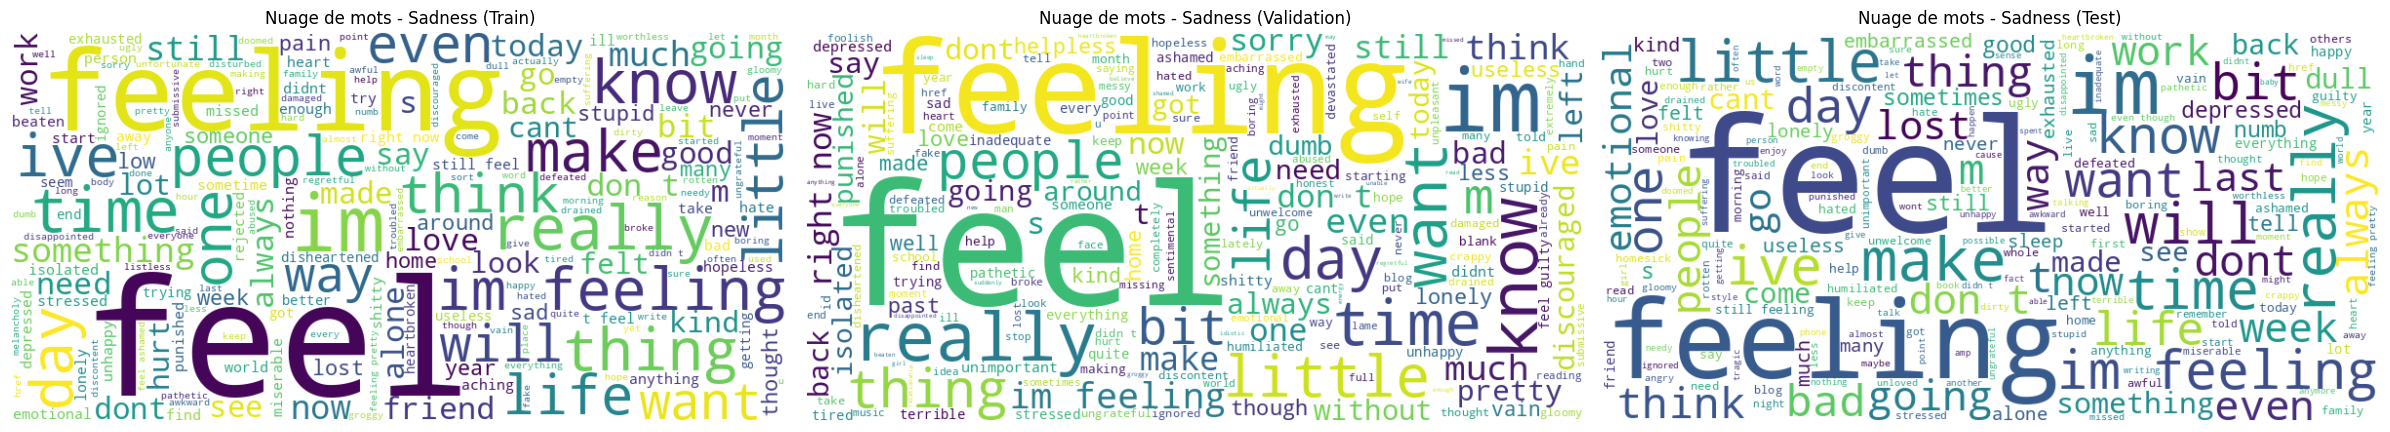

In [ ]:
# SADNESS :

# Train
text_sadness_train = " ".join(train[train['label'] == label_names.index('sadness')]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_sadness_train)

# Validation
text_sadness_validation = " ".join(validation[validation['label'] == label_names.index('sadness')]['text'])
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(text_sadness_validation)

# Test
text_sadness_test = " ".join(test[test['label'] == label_names.index('sadness')]['text'])
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(text_sadness_test)

# Subdivision de l'affichage
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Afficher chaque nuage de mots
axes[0].imshow(wordcloud_1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Nuage de mots - Sadness (Train)")

axes[1].imshow(wordcloud_2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Nuage de mots - Sadness (Validation)")

axes[2].imshow(wordcloud_3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title("Nuage de mots - Sadness (Test)")

# Mise en page
plt.tight_layout()
plt.show()

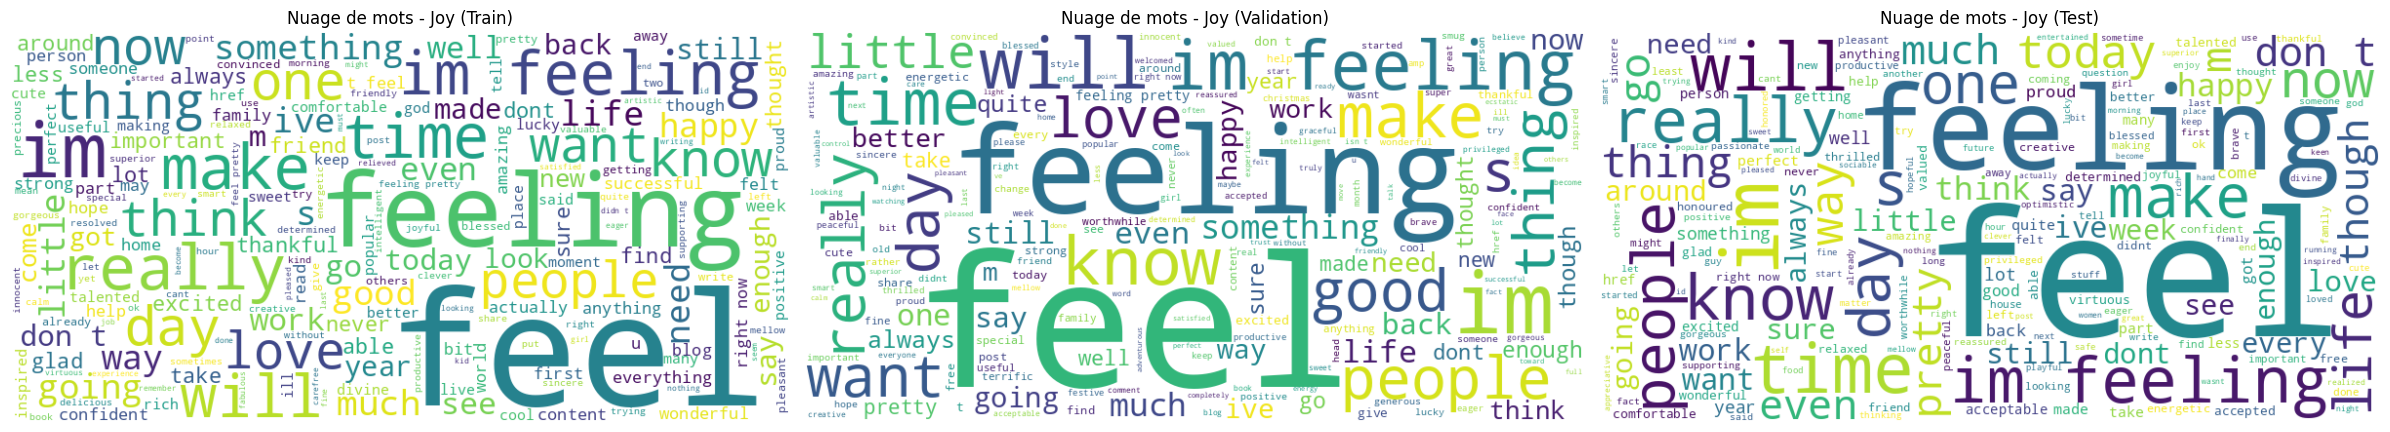

In [ ]:
# JOY

# Train
text_joy_train = " ".join(train[train['label'] == label_names.index('joy')]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_joy_train)

# Validation
text_joy_validation = " ".join(validation[validation['label'] == label_names.index('joy')]['text'])
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(text_joy_validation)

# Test
text_joy_test = " ".join(test[test['label'] == label_names.index('joy')]['text'])
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(text_joy_test)

# Subdivision de l'affichage
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Afficher chaque nuage de mots
axes[0].imshow(wordcloud_1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Nuage de mots - Joy (Train)")

axes[1].imshow(wordcloud_2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Nuage de mots - Joy (Validation)")

axes[2].imshow(wordcloud_3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title("Nuage de mots - Joy (Test)")

# Mise en page
plt.tight_layout()
plt.show()

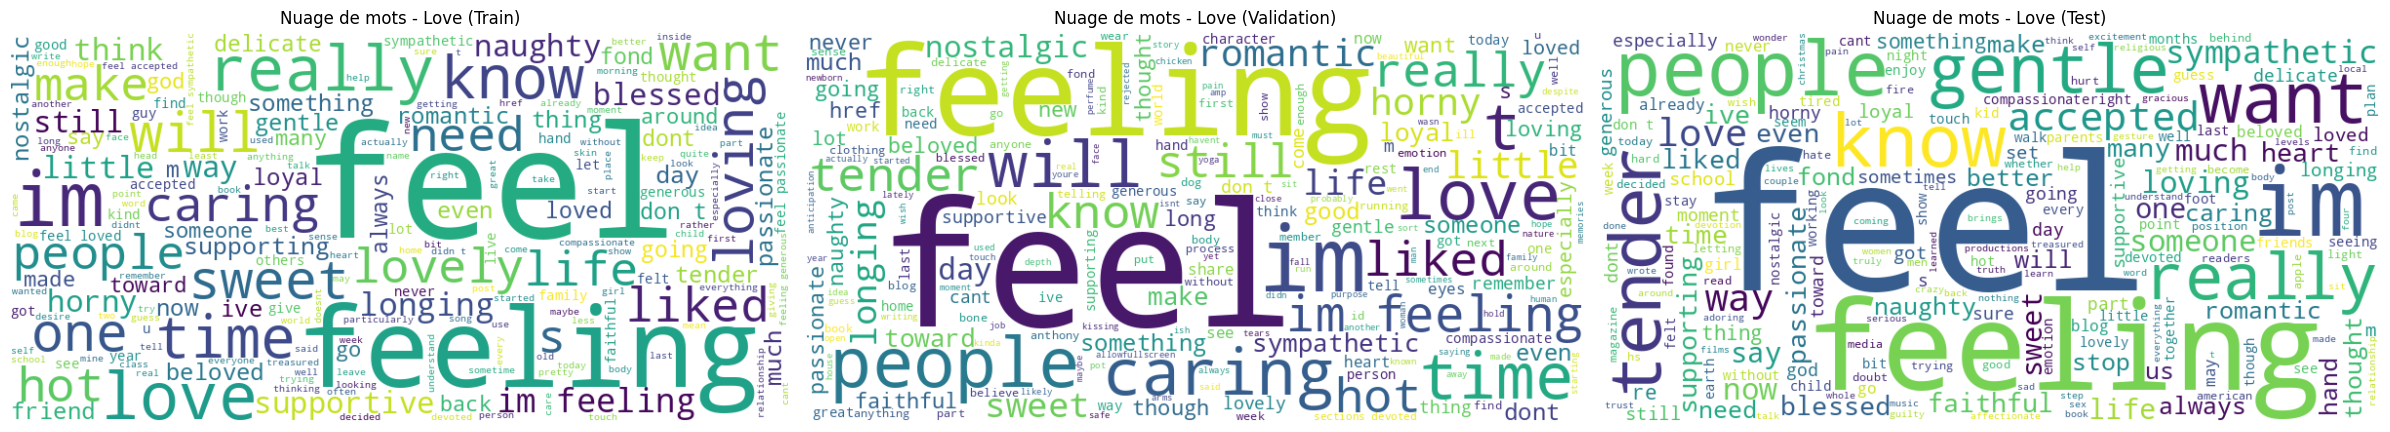

In [ ]:
# LOVE

# Train
text_love_train = " ".join(train[train['label'] == label_names.index('love')]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_love_train)

# Validation
text_love_validation = " ".join(validation[validation['label'] == label_names.index('love')]['text'])
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(text_love_validation)

# Test
text_love_test = " ".join(test[test['label'] == label_names.index('love')]['text'])
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(text_love_test)

# Subdivision de l'affichage
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Afficher chaque nuage de mots
axes[0].imshow(wordcloud_1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Nuage de mots - Love (Train)")

axes[1].imshow(wordcloud_2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Nuage de mots - Love (Validation)")

axes[2].imshow(wordcloud_3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title("Nuage de mots - Love (Test)")

# Mise en page
plt.tight_layout()
plt.show()

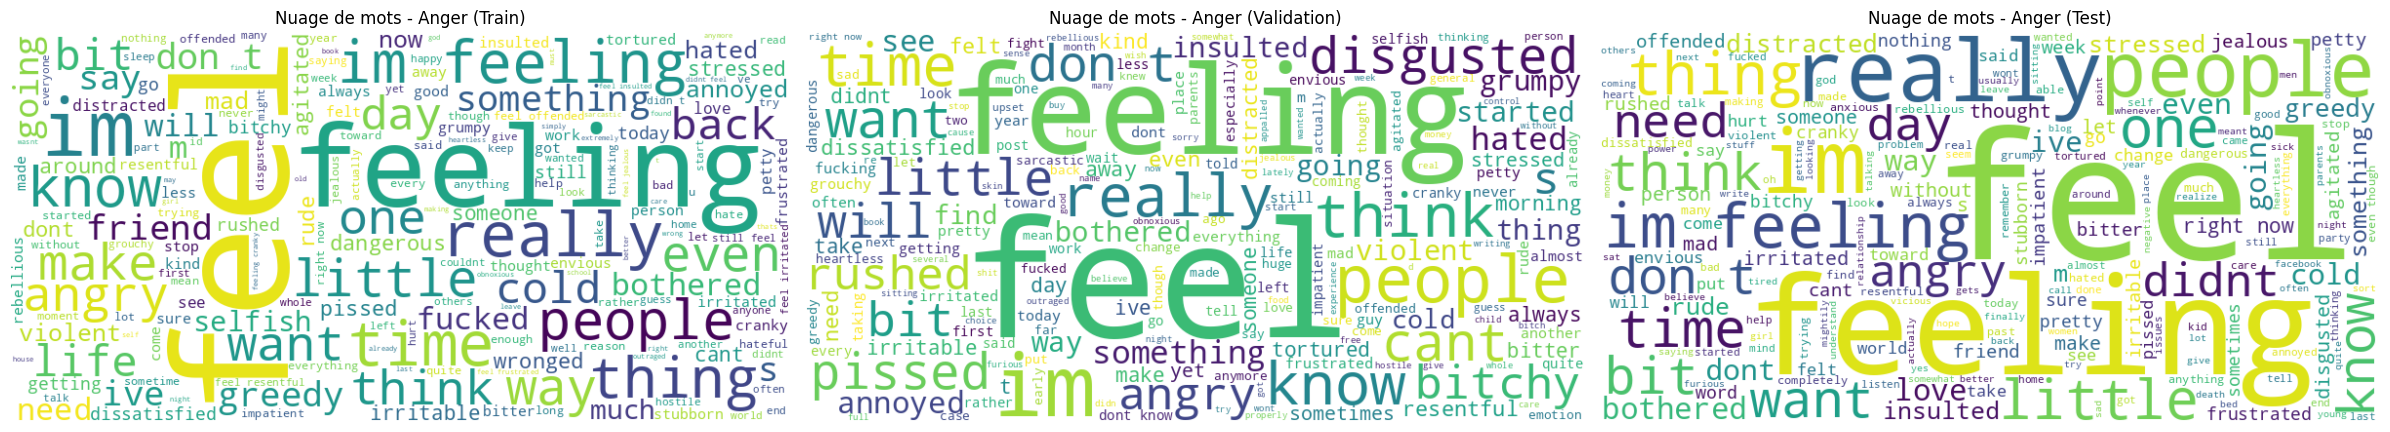

In [ ]:
# ANGER

# Train
text_anger_train = " ".join(train[train['label'] == label_names.index('anger')]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_anger_train)

# Validation
text_anger_validation = " ".join(validation[validation['label'] == label_names.index('anger')]['text'])
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(text_anger_validation)

# Test
text_anger_test = " ".join(test[test['label'] == label_names.index('anger')]['text'])
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(text_anger_test)

# Subdivision de l'affichage
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Afficher chaque nuage de mots
axes[0].imshow(wordcloud_1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Nuage de mots - Anger (Train)")

axes[1].imshow(wordcloud_2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Nuage de mots - Anger (Validation)")

axes[2].imshow(wordcloud_3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title("Nuage de mots - Anger (Test)")

# Mise en page
plt.tight_layout()
plt.show()

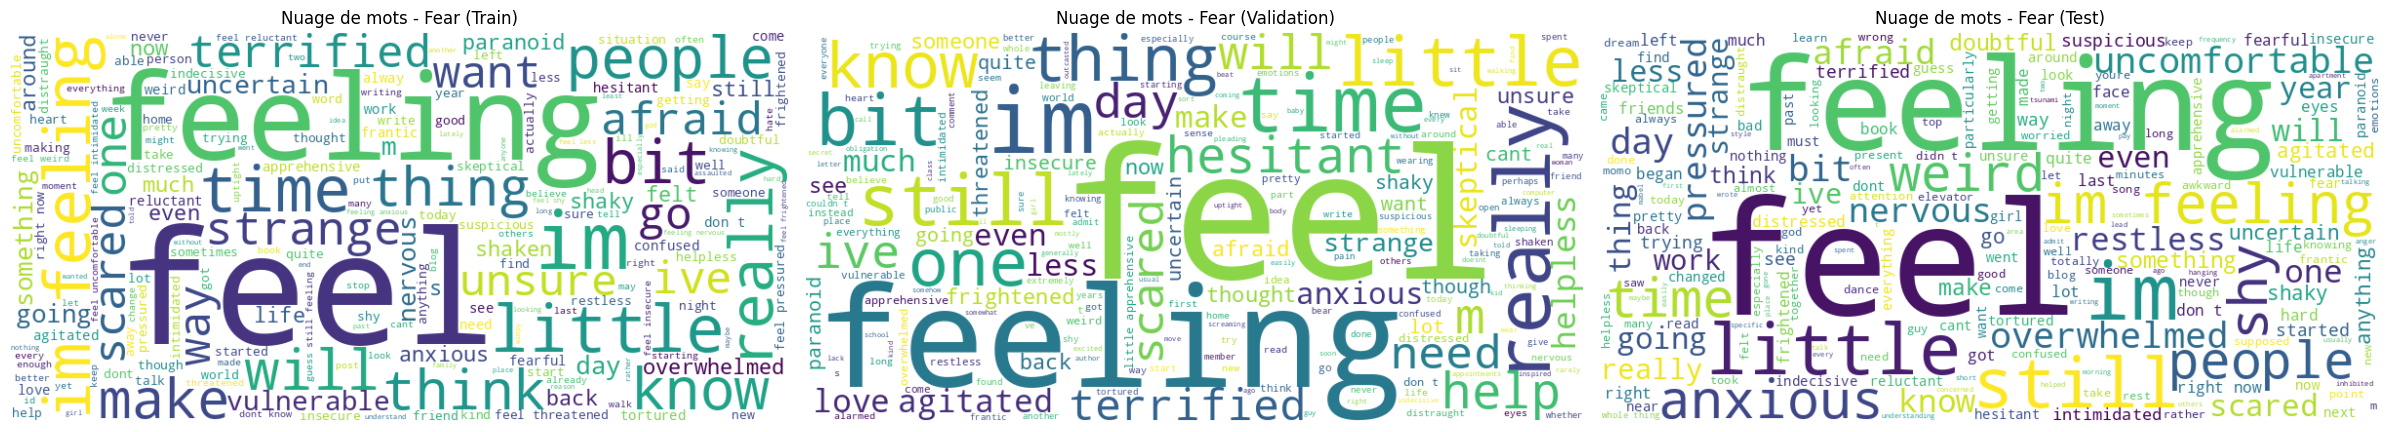

In [ ]:
# FEAR

# Train
text_fear_train = " ".join(train[train['label'] == label_names.index('fear')]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_fear_train)

# Validation
text_fear_validation = " ".join(validation[validation['label'] == label_names.index('fear')]['text'])
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(text_fear_validation)

# Test
text_fear_test = " ".join(test[test['label'] == label_names.index('fear')]['text'])
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(text_fear_test)

# Subdivision de l'affichage
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Afficher chaque nuage de mots
axes[0].imshow(wordcloud_1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Nuage de mots - Fear (Train)")

axes[1].imshow(wordcloud_2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Nuage de mots - Fear (Validation)")

axes[2].imshow(wordcloud_3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title("Nuage de mots - Fear (Test)")

# Mise en page
plt.tight_layout()
plt.show()

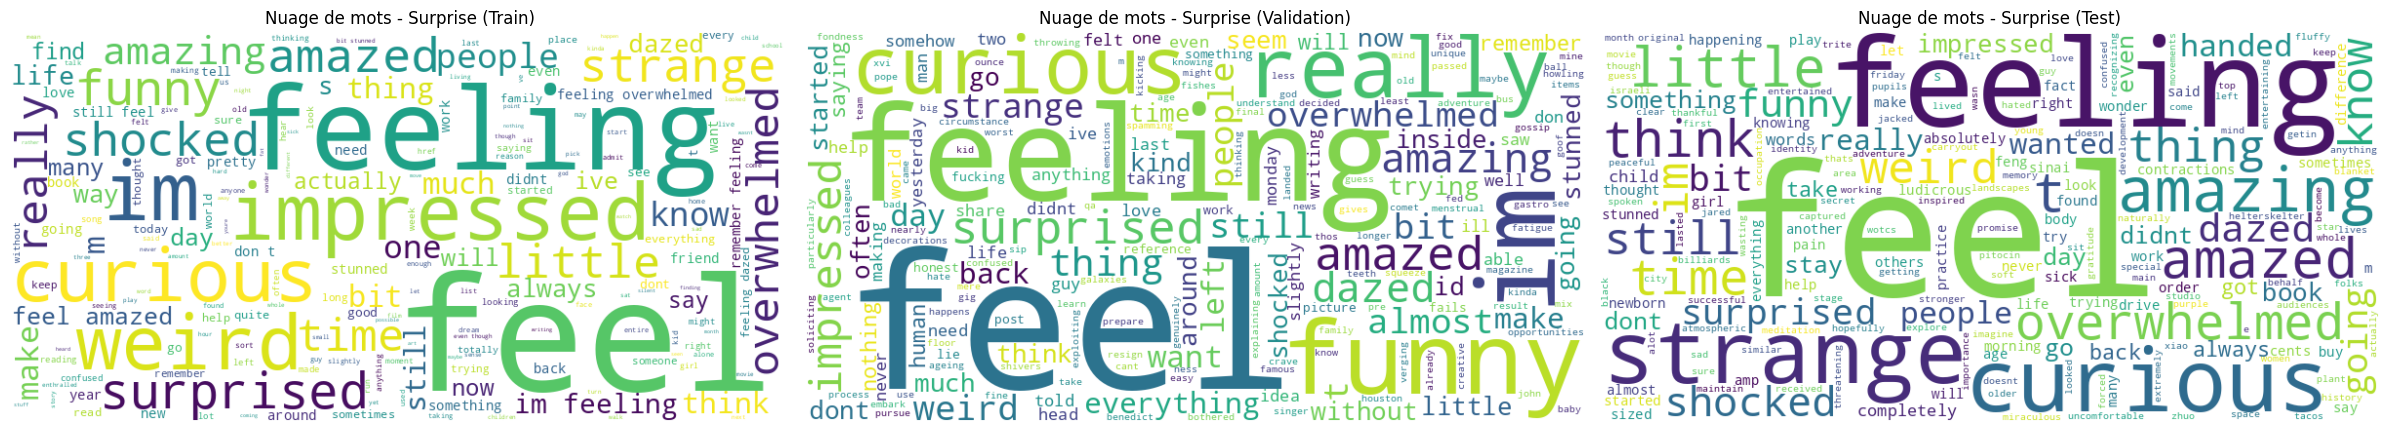

In [ ]:
# SURPRISE

# Train
text_surprise_train = " ".join(train[train['label'] == label_names.index('surprise')]['text'])
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_surprise_train)

# Validation
text_surprise_validation = " ".join(validation[validation['label'] == label_names.index('surprise')]['text'])
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(text_surprise_validation)

# Test
text_surprise_test = " ".join(test[test['label'] == label_names.index('surprise')]['text'])
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(text_surprise_test)

# Subdivision de l'affichage
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Afficher chaque nuage de mots
axes[0].imshow(wordcloud_1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Nuage de mots - Surprise (Train)")

axes[1].imshow(wordcloud_2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Nuage de mots - Surprise (Validation)")

axes[2].imshow(wordcloud_3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title("Nuage de mots - Surprise (Test)")

# Mise en page
plt.tight_layout()
plt.show()

**Observations :**

* On observe que les mots *feel* et *feeling* reviennent pour toutes les émotions dans tous les jeux de données.
* Pour une même émotions, les mêmes mots reviennent pour les 3 sous jeux de données.
* Pour des émotions différentes, d'autres mots qui semblent être plus spécifiques apparaissent, par exemple :
  * Pour *Sadness* : *bad, really, people, sadness*.
  * Pour *Joy* : *happy, people, pretty, better, thankful*.
  * Pour *Love* : *want, carrying, sweet, lovely*.
  * Pour *Anger* : *angry, pissed, fucked, really, people*.
  * Pour *Fear* : *uncertain, terrified, scared, nervous, doubtful*.
  * Pour *Surprise* : *averwhelmed, shocked, dazed, weird, strange*.

---

Maintenant que nous avons brièvement analysé les données, nous allons créer le modèle de classification avec une architecture de *Transformers*.

# 3 - Création du modèle
---

Nous construisons un modèle de classification basé sur une architecture de Transformer. Notre modèle ne comportera qu'un encodeur et sera constitué des 3 sous modules suivants :

Un module d'embedding comprenant :

* Un sous module d'input embedding.
* Un sous module de positional encoding.

Un module de transformer encoder comprenant :

* Multi Head Attention.
* Layer Norm layers.
* Feed-forward.

Une tête de classification formée d'une couche linéaire.

Les différents modules sont développés à la suite. Nous suivons l'ordre proposé par le sujet.

## 3.1 - Multi-head attention

Le mécanisme de **Multi-Head Attention** permet au modèle de se concentrer simultanément sur différentes parties d’une séquence d’entrée. Il consiste à appliquer plusieurs mécanismes d’attention en parallèle (appelés "têtes"), chacun apprenant à extraire des relations différentes entre les tokens.

Chaque tête effectue une attention "scaled dot-product" sur des versions projetées de l’entrée (Q, K, V). Ensuite, les résultats sont concaténés et repassés par une couche linéaire pour obtenir la sortie finale.

Cela permet au modèle de capturer plusieurs types de dépendances contextuelles (ex. : syntaxiques, sémantiques) en une seule étape.



In [ ]:
class MultiHeadAttention(nn.Module) :
    def __init__(self, d_model, num_heads, dropout=0.1) : # d_model = dim du vecteur de chaque token
                                                          # num_heads = nbr de tête d'attention
                                                          # dropout = taux pour la régularisation des poids (évite overfitting)
        super().__init__()
        assert d_model % num_heads == 0 # Vérification que la dimension est divisible par le nombre de tête

        self.num_heads = num_heads
        self.d_k = d_model // num_heads # Dimension de chaque tête d'attention

        self.qkv = nn.Linear(d_model, d_model * 3) # Projette l'entrée vers 3 matrices Q, K, V (Query, Key, Value)
        self.out = nn.Linear(d_model, d_model)     # Projette le résultat des têtes dans l'espace d'origine = Output Linear Layer
        self.dropout = nn.Dropout(dropout)         # Ajoute du dropout pour la régularisation

    def forward(self, x) :
        B, T, C = x.size()                                           # B = batch_size, T = sequence_length, C = d_model
        qkv = self.qkv(x).reshape(B, T, 3, self.num_heads, self.d_k) # Transforme x en Q K V pour chaque tête
        q, k, v = qkv.unbind(dim=2)                                  # On sépare les 3 matrices et on transpose pour avoir
        q, k, v = [t.transpose(1, 2) for t in (q, k, v)]             #  pour avoir (B, num_heads, T, d_k)

        attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_k)  # Attention : produit scalaire entre Q et K transpos" normalisé par sqrt(d_k)
        attn_weights = F.softmax(attn_scores, dim=-1)                  # Softmax pour avoir les poids d'attention
        attn_weights = self.dropout(attn_weights)                      # Dropout appliqué que aux poids

        attn_output = attn_weights @ v                             # Poid d'attention * V pour avoir vecteurs pondérés
        attn_output = attn_output.transpose(1, 2).reshape(B, T, C) # Regroupe les têtes
        return self.out(attn_output)                               # Projection finale vers l'espace d'origine

## 3.2 - Layer normalization

La **Layer Normalization** est une technique de normalisation appliquée à chaque token individuellement, en normalisant les valeurs sur les dimensions du vecteur.

Elle est utilisée pour :
- stabiliser l’apprentissage,
- accélérer la convergence,
- éviter les "explosions" ou "extinctions" de gradients.

Dans les Transformers, elle est souvent utilisée **avant ou après les blocs d’attention ou feedforward**, combinée à des connexions résiduelles.


In [ ]:
class LayerNorm(nn.Module) :
    def __init__(self, emb_dim) :
        super().__init__()
        self.eps = 1e-5                                 # Pour éviter la division par 0
        self.scale = nn.Parameter(torch.ones(emb_dim))  # Paramètre pour ajuster la sortie normalisée
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # Idem

    def forward(self, x) :
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # Normalisation
        y = self.scale * norm_x + self.shift             # Transformation linéaire apprenable
        return y

## 3.3 - Feed-forward sub-module

Le **Feed-Forward Network** (ou FFN) est un petit réseau de neurones appliqué indépendamment à chaque position de la séquence.

Il est composé de deux couches linéaires séparées par une activation non-linéaire (souvent GELU ou ReLU). Il agit comme un transformateur de caractéristiques, en enrichissant chaque vecteur de token sans mélange d'information entre les positions.

Dans l’architecture Transformer, le FFN suit le bloc d’attention pour ajouter de la capacité de transformation non-linéaire à chaque position.


In [ ]:
class FeedForward(nn.Module) :
    def __init__(self, d_model, hidden_dim, dropout=0.1) :
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, hidden_dim), # Projette dans un espace intermédiaire de plus grande dimension
            nn.GELU(),                      # Activation non-linéaire : plus lisse que ReLU svt + efficace en NLP
            nn.Dropout(dropout),            # Dropout pour éviter le surapprentissage
            nn.Linear(hidden_dim, d_model), # Reprojette vers dimension d'origine
            nn.Dropout(dropout)             # Dropout final surtout utile pdt l'entrainement
        )

    def forward(self, x) :
        return self.net(x)

## 3.4 - Transformer encoder block

**Définition :**

In [ ]:
class TransformerEncoderBlock(nn.Module) :
    def __init__(self, d_model, num_heads, hidden_dim, dropout=0.1) :
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads, dropout) # Initialisation du module multi tête
        self.norm1 = LayerNorm(d_model)                             # Normalisation
        self.ff = FeedForward(d_model, hidden_dim, dropout)         # Module FeedForward
        self.norm2 = LayerNorm(d_model)                             # Normalisation
        self.dropout = nn.Dropout(dropout)                          # Normalisation

    def forward(self, x) :
        # Multi-head self-attention avec résidu + norm
        attn_out = self.attn(self.norm1(x)) # On applique l'attention multi-tête
        x = x + self.dropout(attn_out)      # On applique la sortie de l'attention à l'entrée originelle (un peu comme RNN) + Dropout

        # FeedForward avec résidu + norm
        ff_out = self.ff(self.norm2(x))     # On applique la normalisation
        x = x + self.dropout(ff_out)        # Comme avant

        return x

## 3.5 - Input Embedding

**Définition :**

Lors de l'**Embedding**, chaque mot (ou token, voir ci dessous) est transformé en un vecteur numérique qui capture son sens dans le contexte de la phrase.
Cette étape est combinée avec celle du **Positional Encoding** : on ajoute des informations sur la position du mot dans la phrase, permettant ainsi au modèle de comprendre l’ordre des mots, ce qui influence le sens global de la phrase.

Ainsi, les entrées du Transformer encoder block seront les vecteurs issus de cette combinaison. Chaque mot est représenté par un vecteur qui intègre à la fois son sens et sa position.

In [ ]:
# Positional Encoding sinusoïdal (non appris) : matrice sinusoïdale pour garder la position des mots

class PositionalEncodingSinusoidal(nn.Module) :
    def __init__(self, d_model, max_len) :
        super().__init__()
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # Pour les dimensions paires
        pe[:, 1::2] = torch.cos(position * div_term)  # Pour les dimensions impaires
        pe = pe.unsqueeze(0)                          # Shape : (1, max_len, d_model)

        self.register_buffer('positional_encoding', pe)  # non entraînable

    def forward(self, x):
        # x : (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.positional_encoding[:, :seq_len, :]

# Module complet : token embedding + positional encoding

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, d_model, max_len):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncodingSinusoidal(d_model, max_len)

    def forward(self, input_ids):
        x = self.token_embedding(input_ids)  # Shape: (batch, seq_len, d_model)
        x = self.pos_encoding(x)             # Ajoute l'encodage de position
        return x

## 3.6 - Transformer Classifier

**Définition :**

In [ ]:
class TextClassifierTransformer(nn.Module) :
    def __init__(self, vocab_size, d_model, max_len, num_classes, num_layers, cfg_block) :
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncodingSinusoidal(d_model, max_len)

        # Extraire les paramètres du cfg_block
        num_heads = cfg_block["n_heads"]
        hidden_dim = d_model * 4
        dropout = cfg_block["drop_rate"]

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, hidden_dim, dropout)
            for _ in range(num_layers)        # Appliquer les couches d'encodeur successive
        ])
        self.norm = LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids):
        # Embedding des tokens + position
        x = self.token_emb(input_ids)
        x = self.pos_emb(x)

        # Passage à travers les blocs encodeurs
        for block in self.encoder:
            x = block(x)

        # Moyenne sur la séquence pour résumer (pooling)
        x = x.mean(dim=1)

        # Classification
        return self.classifier(x)

# 4 - Token
---

La **tokenisation** est la toute première étape de notre modèle, qui vise à préparer les données d'entrée pour l'apprentissage.

Elle transforme les textes bruts en vecteurs numériques que le modèle peut comprendre.
On utilise ici le tokenizer pré-entraîné de BERT (Bidirectional Encoder Representations from Transformers), formé sur un grand corpus de textes. Il segmente les phrases en mots ou sous-mots appelés **tokens**, puis les convertit en identifiants (input IDs).

Chaque séquence est ensuite automatiquement tronquée ou complétée (padding) à une longueur fixe (max_length = 128) pour garantir une entrée cohérente au modèle.



In [ ]:
# Tokenizer pré-entraîné de BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenisation du dataset avec padding/truncation automatique
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length= 128  # J'ai essayé avec 64, 128 et 256 mais 128 SEMBLE donner les meilleurs résultats
    )

# Appliquer la tokenisation
tokenized_datasets = ds.map(tokenize_function, batched=True)

# Formatage pour PyTorch (convertit les colonnes en Tensors automatiquement)
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Création des DataLoaders
train_loader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size=32)
test_loader = DataLoader(tokenized_datasets["test"], batch_size=32)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# 5 - Entrainement du modèle
---

ll faut désormais entraîner le modèle. Pour cela, on se sert du jeu de données d'apprentissage en le divisant en batch. Cela permet à la fois d'accéler la phase d'entrainement (en évitant de passer les données les unes apreès les autres) mais aussi de ne pas surcharger l'algorithme avec trop de données. Il faut donc trouver un bon compromis concernant la taille du batch.

Lorsque toutes les données ont été passées à l'apprentissage, on dit que le modèle a parcouru une époque. On répète alors les époques pour tenter d'améliorer au maximum la précision du modèle.

Les hyper-paramètres (taille du batch, nombre d'époques, taux d'apprentissage...) peuvent être optimisés à l'aide du jeu de données validations.

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs) :
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs) :
        model.train()
        total_loss, total_correct = 0, 0

        for batch in train_loader :
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device) #### #### ICI j'enlève le s au labels entre crochet

            # Forward
            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss & accuracy
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad() :
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device) #### #### ICI j'enlève le s au labels entre crochet
                outputs = model(input_ids)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_accuracy:.4f}")

In [ ]:
# Configuration des dimensions
cfg_block = {
    "emb_dim" : 128,
    "context_length" : 128,
    "n_heads" : 4,
    "drop_rate" : 0.1,
    "qkv_bias" : True
}

# Instanciation du modèle
model = TextClassifierTransformer(
    vocab_size = tokenizer.vocab_size,
    d_model = 128,
    max_len = 128,
    num_classes = 6,
    num_layers = 2,
    cfg_block = cfg_block
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)

train_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    device = device,
    num_epochs = 30
)

# Pourquoi 27 epoch : parce que ça : ANCIEN TOKEN
# Epoch 24/30
#   Train Loss: 0.0537 | Train Acc: 0.9823
#   Val   Loss: 0.6229 | Val   Acc: 0.8715
# Epoch 25/30
#   Train Loss: 0.0497 | Train Acc: 0.9826
#   Val   Loss: 0.6434 | Val   Acc: 0.8660
# Epoch 26/30
#   Train Loss: 0.0457 | Train Acc: 0.9851
#   Val   Loss: 0.7197 | Val   Acc: 0.8710
# Epoch 27/30
#   Train Loss: 0.0459 | Train Acc: 0.9837
#   Val   Loss: 0.6408 | Val   Acc: 0.8705
# Epoch 28/30
#   Train Loss: 0.0388 | Train Acc: 0.9873
#   Val   Loss: 0.6796 | Val   Acc: 0.8715
# Epoch 29/30
#   Train Loss: 0.0385 | Train Acc: 0.9869
#   Val   Loss: 0.7158 | Val   Acc: 0.8670
# Epoch 30/30
#   Train Loss: 0.0353 | Train Acc: 0.9889
#   Val   Loss: 0.7516 | Val   Acc: 0.8715


# Puis ça : ANCIEN TOKEN
# Epoch 1/27
#   Train Loss: 0.0375 | Train Acc: 0.9867
#   Val   Loss: 0.6807 | Val   Acc: 0.8695
# Epoch 2/27
#   Train Loss: 0.0351 | Train Acc: 0.9874
#   Val   Loss: 0.7568 | Val   Acc: 0.8725
# Epoch 3/27
#   Train Loss: 0.0339 | Train Acc: 0.9896
#   Val   Loss: 0.6739 | Val   Acc: 0.8780
# Epoch 4/27
#   Train Loss: 0.0315 | Train Acc: 0.9892
#   Val   Loss: 0.7227 | Val   Acc: 0.8765
# Epoch 5/27
#   Train Loss: 0.0315 | Train Acc: 0.9896
#   Val   Loss: 0.6637 | Val   Acc: 0.8695
# Epoch 6/27
#   Train Loss: 0.0302 | Train Acc: 0.9899
#   Val   Loss: 0.7260 | Val   Acc: 0.8700
# Epoch 7/27
#   Train Loss: 0.0285 | Train Acc: 0.9903
#   Val   Loss: 0.7120 | Val   Acc: 0.8800
# Epoch 8/27
#   Train Loss: 0.0270 | Train Acc: 0.9914
#   Val   Loss: 0.7305 | Val   Acc: 0.8705
# Epoch 9/27
#   Train Loss: 0.0266 | Train Acc: 0.9909
#   Val   Loss: 0.7356 | Val   Acc: 0.8760
# Epoch 10/27
#   Train Loss: 0.0286 | Train Acc: 0.9897
#   Val   Loss: 0.7946 | Val   Acc: 0.8710
# Epoch 11/27
#   Train Loss: 0.0265 | Train Acc: 0.9911
#   Val   Loss: 0.7898 | Val   Acc: 0.8665
# Epoch 12/27
#   Train Loss: 0.0262 | Train Acc: 0.9922
#   Val   Loss: 0.7705 | Val   Acc: 0.8735
# Epoch 13/27
#   Train Loss: 0.0199 | Train Acc: 0.9939
#   Val   Loss: 0.7988 | Val   Acc: 0.8775
# Epoch 14/27
#   Train Loss: 0.0283 | Train Acc: 0.9911
#   Val   Loss: 0.7560 | Val   Acc: 0.8705
# Epoch 15/27
#   Train Loss: 0.0278 | Train Acc: 0.9909
#   Val   Loss: 0.7695 | Val   Acc: 0.8685
# Epoch 16/27
#   Train Loss: 0.0208 | Train Acc: 0.9936
#   Val   Loss: 0.7166 | Val   Acc: 0.8795
# Epoch 17/27
#   Train Loss: 0.0211 | Train Acc: 0.9926
#   Val   Loss: 0.8088 | Val   Acc: 0.8675
# Epoch 18/27
#   Train Loss: 0.0237 | Train Acc: 0.9921
#   Val   Loss: 0.6927 | Val   Acc: 0.8775
# Epoch 19/27
#   Train Loss: 0.0215 | Train Acc: 0.9923
#   Val   Loss: 0.8493 | Val   Acc: 0.8700
# Epoch 20/27
#   Train Loss: 0.0211 | Train Acc: 0.9929
#   Val   Loss: 0.8506 | Val   Acc: 0.8660
# Epoch 21/27
#   Train Loss: 0.0213 | Train Acc: 0.9927
#   Val   Loss: 0.7754 | Val   Acc: 0.8830
# Epoch 22/27
#   Train Loss: 0.0230 | Train Acc: 0.9923
#   Val   Loss: 0.7464 | Val   Acc: 0.8750
# Epoch 23/27
#   Train Loss: 0.0190 | Train Acc: 0.9938
#   Val   Loss: 0.7525 | Val   Acc: 0.8790
# Epoch 24/27
#   Train Loss: 0.0189 | Train Acc: 0.9933
#   Val   Loss: 0.8407 | Val   Acc: 0.8755
# Epoch 25/27
#   Train Loss: 0.0227 | Train Acc: 0.9928
#   Val   Loss: 0.7713 | Val   Acc: 0.8780
# Epoch 26/27
#   Train Loss: 0.0190 | Train Acc: 0.9932
#   Val   Loss: 0.7712 | Val   Acc: 0.8820
# Epoch 27/27
#   Train Loss: 0.0223 | Train Acc: 0.9922
#   Val   Loss: 0.7881 | Val   Acc: 0.8805


# NOUVEAU TOKEN : TAILLE 64
# Epoch 1/27
#   Train Loss: 1.5846 | Train Acc: 0.3325
#   Val   Loss: 1.5810 | Val   Acc: 0.3390
# Epoch 2/27
#   Train Loss: 1.5557 | Train Acc: 0.3609
#   Val   Loss: 1.5663 | Val   Acc: 0.3405
# Epoch 3/27
#   Train Loss: 1.4661 | Train Acc: 0.4348
#   Val   Loss: 1.4216 | Val   Acc: 0.4620
# Epoch 4/27
#   Train Loss: 1.2451 | Train Acc: 0.5346
#   Val   Loss: 1.1517 | Val   Acc: 0.5755
# Epoch 5/27
#   Train Loss: 0.9345 | Train Acc: 0.6517
#   Val   Loss: 0.9207 | Val   Acc: 0.6645
# Epoch 6/27
#   Train Loss: 0.6663 | Train Acc: 0.7594
#   Val   Loss: 0.7197 | Val   Acc: 0.7365
# Epoch 7/27
#   Train Loss: 0.4609 | Train Acc: 0.8391
#   Val   Loss: 0.5546 | Val   Acc: 0.8190
# Epoch 8/27
#   Train Loss: 0.3305 | Train Acc: 0.8841
#   Val   Loss: 0.4639 | Val   Acc: 0.8540
# Epoch 9/27
#   Train Loss: 0.2591 | Train Acc: 0.9086
#   Val   Loss: 0.4369 | Val   Acc: 0.8695
# Epoch 10/27
#   Train Loss: 0.2062 | Train Acc: 0.9284
#   Val   Loss: 0.4618 | Val   Acc: 0.8630
# Epoch 11/27
#   Train Loss: 0.1762 | Train Acc: 0.9388
#   Val   Loss: 0.4731 | Val   Acc: 0.8590
# Epoch 12/27
#   Train Loss: 0.1557 | Train Acc: 0.9453
#   Val   Loss: 0.4498 | Val   Acc: 0.8785
# Epoch 13/27
#   Train Loss: 0.1318 | Train Acc: 0.9527
#   Val   Loss: 0.4423 | Val   Acc: 0.8815
# Epoch 14/27
#   Train Loss: 0.1169 | Train Acc: 0.9578
#   Val   Loss: 0.5487 | Val   Acc: 0.8700
# Epoch 15/27
#   Train Loss: 0.1030 | Train Acc: 0.9636
#   Val   Loss: 0.4819 | Val   Acc: 0.8800
# Epoch 16/27
#   Train Loss: 0.0909 | Train Acc: 0.9689
#   Val   Loss: 0.5012 | Val   Acc: 0.8800
# Epoch 17/27
#   Train Loss: 0.0837 | Train Acc: 0.9691
#   Val   Loss: 0.4752 | Val   Acc: 0.8805
# Epoch 18/27
#   Train Loss: 0.0736 | Train Acc: 0.9734
#   Val   Loss: 0.4856 | Val   Acc: 0.8820
# Epoch 19/27
#   Train Loss: 0.0751 | Train Acc: 0.9742
#   Val   Loss: 0.5308 | Val   Acc: 0.8840
# Epoch 20/27
#   Train Loss: 0.0703 | Train Acc: 0.9744
#   Val   Loss: 0.5869 | Val   Acc: 0.8725
# Epoch 21/27
#   Train Loss: 0.0577 | Train Acc: 0.9788
#   Val   Loss: 0.6011 | Val   Acc: 0.8720
# Epoch 22/27
#   Train Loss: 0.0593 | Train Acc: 0.9799
#   Val   Loss: 0.5460 | Val   Acc: 0.8815
# Epoch 23/27
#   Train Loss: 0.0558 | Train Acc: 0.9813
#   Val   Loss: 0.5930 | Val   Acc: 0.8830
# Epoch 24/27
#   Train Loss: 0.0513 | Train Acc: 0.9817
#   Val   Loss: 0.6501 | Val   Acc: 0.8735
# Epoch 25/27
#   Train Loss: 0.0493 | Train Acc: 0.9821
#   Val   Loss: 0.6217 | Val   Acc: 0.8785
# Epoch 26/27
#   Train Loss: 0.0427 | Train Acc: 0.9864
#   Val   Loss: 0.6010 | Val   Acc: 0.8780
# Epoch 27/27
#   Train Loss: 0.0477 | Train Acc: 0.9839
#   Val   Loss: 0.6553 | Val   Acc: 0.8800

# # NOUVEAU TOKEN : TAILLE 128
# Epoch 1/27
#   Train Loss: 1.5860 | Train Acc: 0.3302
#   Val   Loss: 1.5784 | Val   Acc: 0.3520
# Epoch 2/27
#   Train Loss: 1.5753 | Train Acc: 0.3379
#   Val   Loss: 1.5694 | Val   Acc: 0.3645
# Epoch 3/27
#   Train Loss: 1.5513 | Train Acc: 0.3748
#   Val   Loss: 1.5286 | Val   Acc: 0.4255
# Epoch 4/27
#   Train Loss: 1.4754 | Train Acc: 0.4438
#   Val   Loss: 1.4681 | Val   Acc: 0.4590
# Epoch 5/27
#   Train Loss: 1.3443 | Train Acc: 0.5056
#   Val   Loss: 1.2956 | Val   Acc: 0.5280
# Epoch 6/27
#   Train Loss: 1.1011 | Train Acc: 0.6086
#   Val   Loss: 1.0522 | Val   Acc: 0.6345
# Epoch 7/27
#   Train Loss: 0.8675 | Train Acc: 0.7030
#   Val   Loss: 0.8688 | Val   Acc: 0.7105
# Epoch 8/27
#   Train Loss: 0.6841 | Train Acc: 0.7701
#   Val   Loss: 0.7083 | Val   Acc: 0.7585
# Epoch 9/27
#   Train Loss: 0.5239 | Train Acc: 0.8215
#   Val   Loss: 0.6262 | Val   Acc: 0.7960
# Epoch 10/27
#   Train Loss: 0.4131 | Train Acc: 0.8570
#   Val   Loss: 0.5671 | Val   Acc: 0.8215
# Epoch 11/27
#   Train Loss: 0.3415 | Train Acc: 0.8790
#   Val   Loss: 0.5229 | Val   Acc: 0.8385
# Epoch 12/27
#   Train Loss: 0.2871 | Train Acc: 0.8982
#   Val   Loss: 0.4671 | Val   Acc: 0.8515
# Epoch 13/27
#   Train Loss: 0.2472 | Train Acc: 0.9116
#   Val   Loss: 0.4354 | Val   Acc: 0.8660
# Epoch 14/27
#   Train Loss: 0.1997 | Train Acc: 0.9291
#   Val   Loss: 0.4474 | Val   Acc: 0.8710
# Epoch 15/27
#   Train Loss: 0.1723 | Train Acc: 0.9386
#   Val   Loss: 0.4867 | Val   Acc: 0.8615
# Epoch 16/27
#   Train Loss: 0.1559 | Train Acc: 0.9441
#   Val   Loss: 0.4971 | Val   Acc: 0.8760
# Epoch 17/27
#   Train Loss: 0.1373 | Train Acc: 0.9499
#   Val   Loss: 0.4771 | Val   Acc: 0.8715
# Epoch 18/27
#   Train Loss: 0.1156 | Train Acc: 0.9605
#   Val   Loss: 0.4834 | Val   Acc: 0.8765
# Epoch 19/27
#   Train Loss: 0.1071 | Train Acc: 0.9607
#   Val   Loss: 0.5165 | Val   Acc: 0.8765
# Epoch 20/27
#   Train Loss: 0.1000 | Train Acc: 0.9634
#   Val   Loss: 0.5225 | Val   Acc: 0.8775
# Epoch 21/27
#   Train Loss: 0.0934 | Train Acc: 0.9674
#   Val   Loss: 0.5350 | Val   Acc: 0.8770
# Epoch 22/27
#   Train Loss: 0.0863 | Train Acc: 0.9689
#   Val   Loss: 0.5227 | Val   Acc: 0.8840
# Epoch 23/27
#   Train Loss: 0.0739 | Train Acc: 0.9735
#   Val   Loss: 0.5311 | Val   Acc: 0.8870
# Epoch 24/27
#   Train Loss: 0.0651 | Train Acc: 0.9773
#   Val   Loss: 0.5480 | Val   Acc: 0.8855
# Epoch 25/27
#   Train Loss: 0.0601 | Train Acc: 0.9800
#   Val   Loss: 0.5504 | Val   Acc: 0.8805
# Epoch 26/27
#   Train Loss: 0.0619 | Train Acc: 0.9782
#   Val   Loss: 0.5739 | Val   Acc: 0.8805
# Epoch 27/27
#   Train Loss: 0.0555 | Train Acc: 0.9820
#   Val   Loss: 0.5276 | Val   Acc: 0.8850

# NOUVEAU TOJEN : TAILLE 256 : ACCURACY PAS MAL MAIS LOSS NULLEEEEE
# Epoch 1/27
#   Train Loss: 1.5874 | Train Acc: 0.3207
#   Val   Loss: 1.5853 | Val   Acc: 0.3520
# Epoch 2/27
#   Train Loss: 1.5793 | Train Acc: 0.3308
#   Val   Loss: 1.5828 | Val   Acc: 0.3410
# Epoch 3/27
#   Train Loss: 1.5744 | Train Acc: 0.3415
#   Val   Loss: 1.5770 | Val   Acc: 0.3520
# Epoch 4/27
#   Train Loss: 1.5619 | Train Acc: 0.3632
#   Val   Loss: 1.5583 | Val   Acc: 0.3935
# Epoch 5/27
#   Train Loss: 1.4711 | Train Acc: 0.4442
#   Val   Loss: 1.4025 | Val   Acc: 0.4905
# Epoch 6/27
#   Train Loss: 1.2827 | Train Acc: 0.5316
#   Val   Loss: 1.2584 | Val   Acc: 0.5505
# Epoch 7/27
#   Train Loss: 1.1398 | Train Acc: 0.5744
#   Val   Loss: 1.1673 | Val   Acc: 0.5695
# Epoch 8/27
#   Train Loss: 1.0386 | Train Acc: 0.6047
#   Val   Loss: 1.0313 | Val   Acc: 0.6175
# Epoch 9/27
#   Train Loss: 0.8866 | Train Acc: 0.6703
#   Val   Loss: 0.9088 | Val   Acc: 0.6820
# Epoch 10/27
#   Train Loss: 0.7798 | Train Acc: 0.7047
#   Val   Loss: 0.8735 | Val   Acc: 0.6950
# Epoch 11/27
#   Train Loss: 0.7243 | Train Acc: 0.7226
#   Val   Loss: 0.8502 | Val   Acc: 0.7040
# Epoch 12/27
#   Train Loss: 0.6781 | Train Acc: 0.7394
#   Val   Loss: 0.8533 | Val   Acc: 0.6855
# Epoch 13/27
#   Train Loss: 0.6321 | Train Acc: 0.7561
#   Val   Loss: 0.8412 | Val   Acc: 0.7255
# Epoch 14/27
#   Train Loss: 0.5678 | Train Acc: 0.7879
#   Val   Loss: 0.7814 | Val   Acc: 0.7440
# Epoch 15/27
#   Train Loss: 0.4896 | Train Acc: 0.8215
#   Val   Loss: 0.6901 | Val   Acc: 0.7770
# Epoch 16/27
#   Train Loss: 0.4157 | Train Acc: 0.8515
#   Val   Loss: 0.6150 | Val   Acc: 0.8000
# Epoch 17/27
#   Train Loss: 0.3542 | Train Acc: 0.8741
#   Val   Loss: 0.6166 | Val   Acc: 0.8160
# Epoch 18/27
#   Train Loss: 0.3090 | Train Acc: 0.8892
#   Val   Loss: 0.6007 | Val   Acc: 0.8295
# Epoch 19/27
#   Train Loss: 0.2541 | Train Acc: 0.9081
#   Val   Loss: 0.5829 | Val   Acc: 0.8395
# Epoch 20/27
#   Train Loss: 0.2191 | Train Acc: 0.9211
#   Val   Loss: 0.6469 | Val   Acc: 0.8170
# Epoch 21/27
#   Train Loss: 0.1930 | Train Acc: 0.9313
#   Val   Loss: 0.6454 | Val   Acc: 0.8475
# Epoch 22/27
#   Train Loss: 0.1569 | Train Acc: 0.9437
#   Val   Loss: 0.5162 | Val   Acc: 0.8695
# Epoch 23/27
#   Train Loss: 0.1417 | Train Acc: 0.9483
#   Val   Loss: 0.5086 | Val   Acc: 0.8660
# Epoch 24/27
#   Train Loss: 0.1287 | Train Acc: 0.9543
#   Val   Loss: 0.5183 | Val   Acc: 0.8730
# Epoch 25/27
#   Train Loss: 0.1119 | Train Acc: 0.9594
#   Val   Loss: 0.5598 | Val   Acc: 0.8595
# Epoch 26/27
#   Train Loss: 0.1024 | Train Acc: 0.9637
#   Val   Loss: 0.5802 | Val   Acc: 0.8705
# Epoch 27/27
#   Train Loss: 0.1013 | Train Acc: 0.9646
#   Val   Loss: 0.5129 | Val   Acc: 0.8735

Epoch 1/30
  Train Loss: 1.5355 | Train Acc: 0.3741
  Val   Loss: 1.3481 | Val   Acc: 0.4560
Epoch 2/30
  Train Loss: 0.9710 | Train Acc: 0.6445
  Val   Loss: 0.6973 | Val   Acc: 0.7470
Epoch 3/30
  Train Loss: 0.5467 | Train Acc: 0.8079
  Val   Loss: 0.5248 | Val   Acc: 0.8150


# 6 - Test du modèle
---

In [ ]:
def test_model(model, loader, device) :
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            x = batch["input_ids"].to(device)
            y = batch["label"].to(device) ### ATTENTIONNNNN : S ENLEVÉ ICI AU LABELS APRÈS CHANGEMENT TOKEN
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    print(f" Test accuracy: {correct / total:.4f}")

test_model(model, test_loader, device)

 Test accuracy: 0.8440


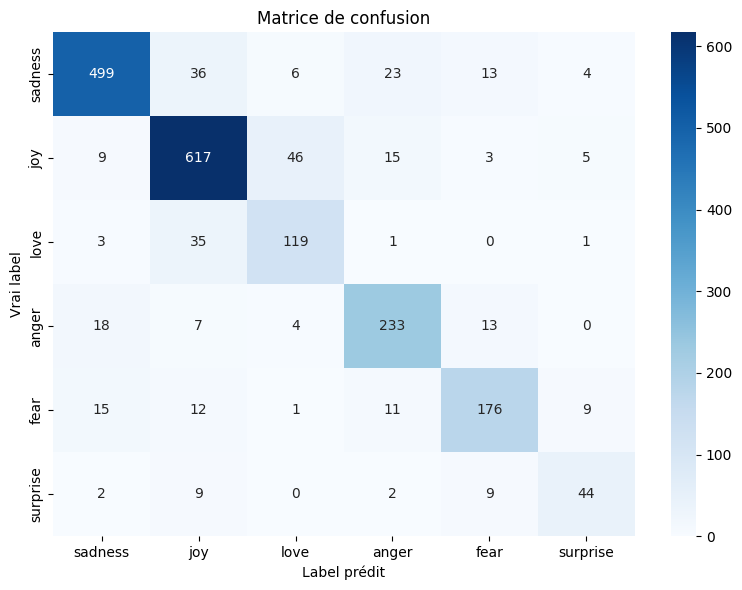

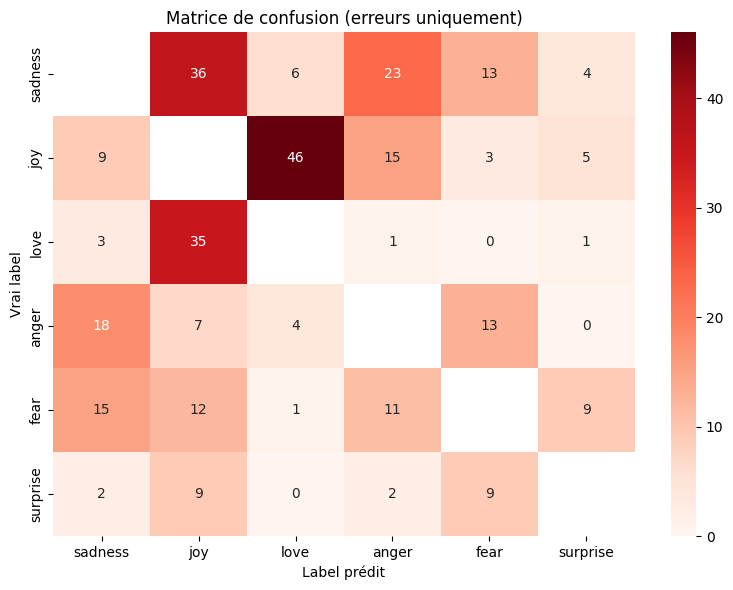

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrices(model, loader, label_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            preds = model(input_ids).argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    # Affichage 1 : matrice complète (classique)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, cbar=True)
    plt.ylabel("Vrai label")
    plt.xlabel("Label prédit")
    plt.title("Matrice de confusion")
    plt.tight_layout()
    plt.show()

    # Affichage 2 : erreurs uniquement (masque la diagonale)
    mask = np.eye(len(label_names), dtype=bool)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=label_names, yticklabels=label_names,
                cbar=True, mask=mask)
    plt.ylabel("Vrai label")
    plt.xlabel("Label prédit")
    plt.title("Matrice de confusion (erreurs uniquement)")
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(model, test_loader, label_names, device)


Le modèle prédit trop souvent "love" à la place de "joy" et "joy" à la place de "love". Cela reste compréhensible car ces émotions sont proches. Par ailleurs, des phrases associées au sentiment "joy" et "love" peuvent faire intervenir le même vocabulaire, ne permettant pas au modèle de bien différencier ces deux émotions.

En revanche, les erreurs fréquentes "joy" à la place de "sadness" (36 fois) sont plus surprenantes. Cela pourrait s’expliquer par la surreprésentation de "joy" dans les données d’apprentissage.

In [ ]:
def predict_emotion(model, tokenizer, text, device, max_len = 64) :
    model.eval()
    with torch.no_grad() :
        inputs = tokenizer(
            text,
            padding = "max_length",
            truncation = True,
            max_length = max_len,
            return_tensors = "pt"
        )
        input_ids = inputs["input_ids"].to(device)
        outputs = model(input_ids)
        probs = torch.softmax(outputs, dim = 1)
        pred = torch.argmax(probs, dim = 1).item()
        return pred, probs[0][pred].item()

In [ ]:
# Exemples

texts = [
    "I feel sadness.",                        # Premiers exemples faciles : utilisation exacte des noms des labels
    "I feel joy.",
    "I feel love.",
    "I feel anger.",
    "I feel fear.",
    "I feel surprise.",
    "I'm feeling sad.",                       # Deuxièmes exemples : utilisation de la structure "I'm feeling + emotion"
    "I'm feeling joyfull.",
    "I'm feeling loved.",
    "I'm feeling angry.",
    "I'm feeling scared.",
    "I'm feeling surprised.",
    "I'm not feeling sad.",                   # Troisièmes exemples : utilisation de la négation
    "I'm not feeling joyfull.",
    "I'm not feeling loved.",
    "I'm not feeling angry.",
    "I'm not feeling scared.",
    "I'm not feeling surprised.",
    "This story upset me, I was devastated.", # Quatrièmes exemples : utilisation des émotions avec un vocabulaire différent
    "I finally graduated after 6 years of hard work!",
    "We are finally getting married!",
    "I could kill him for what he did.",
    "I'm affraid of the truth",
    "I did not expect that from her!"
]

for i, text in enumerate(texts, 1) :
    pred, conf = predict_emotion(model, tokenizer, text, device)
    print(f"text_{i}: {text} → Predicted emotion: {label_names[pred]} (confidence: {conf:.2f})")

# Ces résultats sont pas mal ça montre bien le pb de la négation :

# text_1: I feel sadness. → Predicted emotion: anger (confidence: 0.70)
# text_2: I feel joy. → Predicted emotion: joy (confidence: 1.00)
# text_3: I feel love. → Predicted emotion: joy (confidence: 0.67)
# text_4: I feel anger. → Predicted emotion: anger (confidence: 0.41)
# text_5: I feel fear. → Predicted emotion: anger (confidence: 0.39)
# text_6: I feel surprise. → Predicted emotion: love (confidence: 0.39)
# text_7: I'm feeling sad. → Predicted emotion: sadness (confidence: 1.00)
# text_8: I'm feeling joyfull. → Predicted emotion: joy (confidence: 1.00)
# text_9: I'm feeling loved. → Predicted emotion: love (confidence: 0.89)
# text_10: I'm feeling angry. → Predicted emotion: anger (confidence: 0.97)
# text_11: I'm feeling scared. → Predicted emotion: fear (confidence: 1.00)
# text_12: I'm feeling surprised. → Predicted emotion: surprise (confidence: 1.00)
# text_13: I'm not feeling sad. → Predicted emotion: sadness (confidence: 1.00)
# text_14: I'm not feeling joyfull. → Predicted emotion: joy (confidence: 1.00)
# text_15: I'm not feeling loved. → Predicted emotion: love (confidence: 0.98)
# text_16: I'm not feeling angry. → Predicted emotion: anger (confidence: 1.00)
# text_17: I'm not feeling scared. → Predicted emotion: fear (confidence: 1.00)
# text_18: I'm not feeling surprised. → Predicted emotion: surprise (confidence: 1.00)
# text_19: This story upset me, I was devastated. → Predicted emotion: sadness (confidence: 1.00)
# text_20: I finally graduated after 6 years of hard work! → Predicted emotion: joy (confidence: 0.69)
# text_21: We are finally getting married! → Predicted emotion: joy (confidence: 0.94)
# text_22: I could kill him for what he did. → Predicted emotion: sadness (confidence: 0.87)
# text_23: I'm affraid of the truth → Predicted emotion: fear (confidence: 1.00)
# text_24: I did not expect that from her! → Predicted emotion: joy (confidence: 0.77)

text_1: I feel sadness. → Predicted emotion: sadness (confidence: 0.86)
text_2: I feel joy. → Predicted emotion: joy (confidence: 1.00)
text_3: I feel love. → Predicted emotion: joy (confidence: 0.96)
text_4: I feel anger. → Predicted emotion: sadness (confidence: 0.92)
text_5: I feel fear. → Predicted emotion: joy (confidence: 0.95)
text_6: I feel surprise. → Predicted emotion: joy (confidence: 0.61)
text_7: I'm feeling sad. → Predicted emotion: joy (confidence: 0.97)
text_8: I'm feeling joyfull. → Predicted emotion: joy (confidence: 1.00)
text_9: I'm feeling loved. → Predicted emotion: love (confidence: 0.99)
text_10: I'm feeling angry. → Predicted emotion: anger (confidence: 1.00)
text_11: I'm feeling scared. → Predicted emotion: fear (confidence: 1.00)
text_12: I'm feeling surprised. → Predicted emotion: surprise (confidence: 1.00)
text_13: I'm not feeling sad. → Predicted emotion: joy (confidence: 0.99)
text_14: I'm not feeling joyfull. → Predicted emotion: joy (confidence: 1.00)


Le modèle fonctionne correctement dans les cas clairs ("I am very happy today") mais montre des limites sur les ambigües.
Cela s'explique par sa structure légère, l'absence de pré-entraînement, et la taille limitée du dataset.

Par ailleurs, le modèle rencontre aussi des difficultés sur des phrases courtes du type "I'm not feeling + adj". Cela peut s'expliquer par le fait que le modèle, dans le cas de phrases courtes, accorde trop "d'attention", d'intérêt, à l'adjectif prédominant du commentaire.

Exemple : I am not joyful : le modèle va se focalier sur l'adjectif joyful et va donc penser (à tord) que l'émotion associée à ce commentaire est la joie.

Cela montre que notre modèle, bien qu'ayant une précision satisfaisante sur le jeu de données test, est encore largement perfectible.
Une piste d'amélioration envisagée serait alors de tenter de pénaliser cette trop grande attention portée sur certains mots (comme happy, joyful, sad...) empêchant l'algorithme de détecter ce qu'il se passe autour de ces mots.
Cela pourrait être fait de plusieurs façon :    
- augmenter le jeu de données d'apprentissage, avec ce genre de phrases courtes et des structures en "I am not + adj" (tout en veillant au sur-apprentissage).
- essayer d'optimiser les hyperparamètres pour améliorer encore plus les précisions de l'algorithme